# Create new utility function

Import data.

In [1]:
%load_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.from_sdf(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

load data


In [2]:
building_blocks = dg.datasets.enamine(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630.fpb')

# align fingerprints to building blocks
print('align fingerprints')
fingerprints = dg.utils.sort_fingerprints(fingerprints, building_blocks)

# partition building blocks according to functional groups
print('partition building blocks')
templates = dg.utils.get_unique_reactants(reactions)
building_blocks = dg.utils.partition_building_blocks(building_blocks, templates, out_dir=path)

align fingerprints
partition building blocks


Create inputs to the DrugEnv.

In [398]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

# create assays
log_P_oracle = RDKitOracle('MolLogP')
log_S_oracle = DGLOracle('GCN_canonical_ESOL')
assays = [log_S_oracle, log_P_oracle]

# create evaluators
# ideal = (-2, 0)
log_S_evaluator = ClassicEvaluator(ideal=(-2, 0), acceptable=(-4, 0.5))
# ideal = (1, 4)
log_P_evaluator = ClassicEvaluator(ideal=(1, 4), acceptable=(0, 5))

# create utility function
utility_function = UtilityFunction(
    evaluators = [log_S_evaluator, log_P_evaluator],
    strategy = lambda x: np.prod(x)
)

worst_molecules = np.argsort(drug_agent.policy(deck))[:25].tolist()

First, set up the environment.

In [399]:
from dgym.envs.drug_env import DrugEnv
from dgym.agents import HardcodedDrugAgent
from tqdm.notebook import tqdm

results = []
budgets = [10, 20, 30, 40, 50, 100, 150,
           200, 300, 400, 500, 1_000]
for budget in budgets:
    
    print('Budget:\t', budget)
    
    for trial in tqdm(range(20)):
        
        drug_env = DrugEnv(
            library_designer,
            library = deck[worst_molecules],
            assays = assays,
            budget = budget,
            utility_function=utility_function,
        )

        drug_agent = HardcodedDrugAgent(
            action_space=drug_env.action_space,
            scoring_functions=assays,
            utility_function=utility_function,
            epsilon=0.33,
            fraction_random=0.2,
            num_analogs=1,
            branch_factor=5
        )

        observations, info = drug_env.reset()

        while True:
            
            action = drug_agent.act(observations)
            observations, reward, terminated, truncated, info = drug_env.step(action)
            result = {'budget': budget, 'trial': trial}

            if terminated:
                result.update({'outcome': 1})
                break
            if truncated:
                result.update({'outcome': 0})
                break

        results.append(result)

Budget:	 10


  0%|          | 0/20 [00:00<?, ?it/s]

Budget:	 20


  0%|          | 0/20 [00:00<?, ?it/s]

Budget:	 30


  0%|          | 0/20 [00:00<?, ?it/s]

Budget:	 40


  0%|          | 0/20 [00:00<?, ?it/s]

Budget:	 50


  0%|          | 0/20 [00:00<?, ?it/s]

Budget:	 100


  0%|          | 0/20 [00:00<?, ?it/s]

Budget:	 150


  0%|          | 0/20 [00:00<?, ?it/s]

Budget:	 200


  0%|          | 0/20 [00:00<?, ?it/s]

Budget:	 300


  0%|          | 0/20 [00:00<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_488/3160607556.py", line 37, in <module>
    observations, reward, terminated, truncated, info = drug_env.step(action)
                                                        ^^^^^^^^^^^^^^^^^^^^^
  File "/home/mrr/dev/chodera/dgym/dgym/envs/drug_env.py", line 145, in step
    self.orders.append(self.perform_order(action_type, molecules, *parameters))
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mrr/dev/chodera/dgym/dgym/envs/drug_env.py", line 179, in perform_order
    valid_indices = [m for m in molecule_indices if self.valid_actions[m]]
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mrr/dev/chodera/dgym/dgym/envs/drug_env.py", line 179, in <listcomp>
    val

In [400]:
action

{'type': 1, 'molecules': [103, 106, 116, 57, 101], 'parameters': {}}

<Axes: xlabel='budget', ylabel='outcome'>

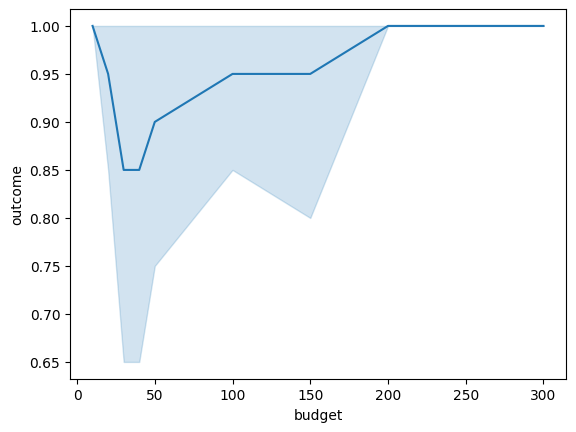

In [406]:
import pandas as pd
sns.lineplot(
    pd.DataFrame(results),
    x='budget',
    y='outcome',
    # errorbar='sd'
)

Draw lineage of best molecule.

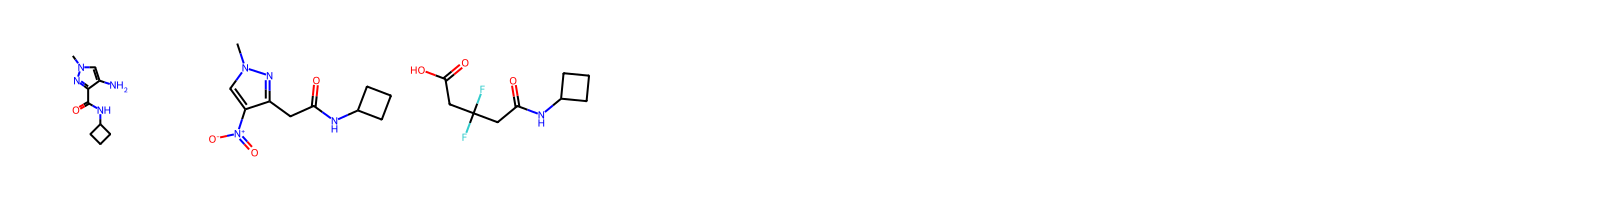

0.6207067290842531		0.6106847879787286		1


(-1.2017120122909546, 0.2845999999999995)

(-2.2398717403411865, 0.5394999999999999)

(-0.9800273180007935, 1.1551999999999998)

In [339]:
from rdkit.Chem import Draw

utility = drug_agent.policy(observations)
index = int(np.argsort(utility)[-1])

mol = drug_env.library[index]
lineage = [mol]
while mol.inspiration:
    mol = mol.inspiration
    lineage.insert(0, mol)

assay_results = [assay(lineage) for assay in assays]
results = [
    utility_function.score(properties)
    for properties in zip(*assay_results)
]

display(Draw.MolsToGridImage(
    [m.mol for m in lineage],
    molsPerRow=8,
    maxMols=10_000
))

print('\t\t'.join(map(str, results)))
display(*zip(*assay_results))